In [1]:
%load_ext autoreload
%autoreload 2
import os
import torch as t
from utils.config import opt
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
import numpy as np
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
labels_dict = {
    '0' : 'aeroplane',
    '1' : 'bicycle',
    '2' : 'bird',
    '3' : 'boat',
    '4' : 'bottle',
    '5' : 'bus',
    '6' : 'car',
    '7' : 'cat',
    '8' : 'chair',
    '9' : 'cow',
    '10' : 'diningtable',
    '11' : 'dog',
    '12' : 'horse',
    '13' : 'motorbike',
    '14' : 'person',
    '15' : 'pottedplant',
    '16' : 'sheep',
    '17' : 'sofa',
    '18' : 'train',
    '19' : 'tvmonitor'
}

In [3]:
image_name = 'demo'
img = cv2.imread(f"../simple-faster-rcnn-pytorch\misc\{image_name}.jpg")
img = t.from_numpy(img)[None]
img = img.permute(0,3,1,2)
img.shape

torch.Size([1, 3, 375, 500])

In [4]:
os.makedirs('overlayed', exist_ok=True)

In [5]:
def overlay_masks(masks_dir  , image_path):
    image= cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    masks = os.listdir(masks_dir)
    image_name = image_path.split('/')[-1].split('.')[0]
    os.makedirs(f'overlayed/{image_name}', exist_ok=True)
    for mask_name in masks:
        mask_path = os.path.join(masks_dir, mask_name)
        mask = cv2.imread(mask_path)
        # mask is a 3 channel image, we only need one channel which is binary
        mask = mask[:,:,0]
        mask = mask/255

        # overlay mask on image
        overlay = image.copy()
        overlay[:,:,0] = mask*image[:,:,0]
        overlay[:,:,1] = mask*image[:,:,1]
        overlay[:,:,2] = mask*image[:,:,2]

        # save overlayed image
        cv2.imwrite(f'overlayed/{image_name}/{mask_name}', overlay)

In [ ]:
overlay_masks('../simple-faster-rcnn-pytorch\Masks2' , '../simple-faster-rcnn-pytorch\misc\demo.jpg')

In [7]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

C:\Users\krish\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\krish\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Setting up a new session...
Traceback (most recent call last):
  File "c:\Users\krish\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\krish\AppData\Local\Pr

Exception in user code:
------------------------------------------------------------


[array([ 6, 12, 14, 14])]
[array([[ 94.714874 ,   2.5186157, 193.54337  , 138.25752  ],
       [ 73.5952   , 207.23288  , 353.66205  , 415.0887   ],
       [ 21.700844 , 268.66763  , 238.67511  , 342.34262  ],
       [124.0995   , 432.82547  , 165.5541   , 453.1802   ]],
      dtype=float32)]
[array([0.99960107, 0.99824846, 0.97678626, 0.9754944 ], dtype=float32)]
[array([[1.40725831e-02, 1.44929736e-05, 3.70689777e-05, 3.68097176e-06,
        1.09120083e-05, 3.50050664e-06, 2.64938499e-05, 3.06332986e-05,
        1.73291767e-06, 6.14998135e-06, 7.89202808e-04, 2.09924542e-06,
        5.88587172e-05, 9.84360397e-01, 1.45392871e-04, 3.58917227e-04,
        1.10661767e-05, 2.89089694e-05, 7.76945762e-06, 2.91960041e-05,
        9.32172611e-07],
       [2.51063138e-01, 1.12188762e-04, 3.07113718e-04, 1.40780656e-04,
        1.30054017e-04, 1.36433417e-04, 1.00080375e-04, 5.32770355e-04,
        2.65811505e-05, 2.63507507e-04, 2.91117909e-03, 2.45868505e-05,
        1.94790642e-04, 6.83620

<Axes: >

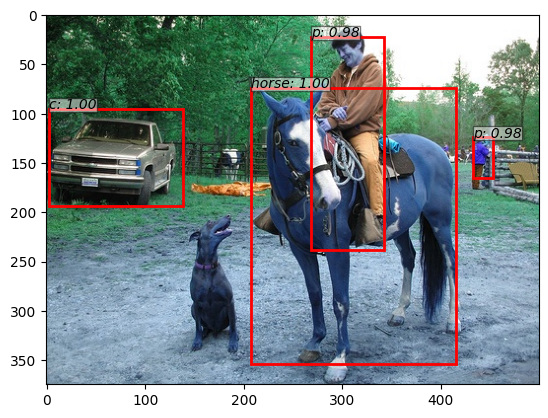

In [8]:
trainer.load('../fasterrcnn_12211511_0.701052458187_torchvision_pretrain.pth')
opt.caffe_pretrain=False # this model was trained from torchvision-pretrained model
_bboxes, _labels, _scores , _probabilities = trainer.faster_rcnn.predict(img,visualize=True)
print(_labels)
print(_bboxes)
print(_scores)
# _probabilities = np.array(_probabilities)
print(_probabilities)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))
# it failed to find the dog, but if you set threshold from 0.7 to 0.6, you'll find it

In [10]:
detectiontxt = f'model_detections/labels/{image_name}.txt'

os.makedirs(os.path.dirname(detectiontxt), exist_ok=True)

with open(detectiontxt, 'a') as f:
    for i in range(len(_labels[0])):
        label = _labels[0][i]
        score = _scores[0][i]
        bbox = _bboxes[0][i]
        probability = _probabilities[0][i]
        line = (label, *bbox, *probability)
        print(line)
        # Write the line to the file
        f.write(("%g " *len(line)).rstrip() % line + "\n")
        

(6, 94.714874, 2.5186157, 193.54337, 138.25752, 0.014072583, 1.4492974e-05, 3.7068978e-05, 3.6809718e-06, 1.0912008e-05, 3.5005066e-06, 2.649385e-05, 3.06333e-05, 1.7329177e-06, 6.1499813e-06, 0.0007892028, 2.0992454e-06, 5.8858717e-05, 0.9843604, 0.00014539287, 0.00035891723, 1.1066177e-05, 2.890897e-05, 7.769458e-06, 2.9196004e-05, 9.321726e-07)
(12, 73.5952, 207.23288, 353.66205, 415.0887, 0.25106314, 0.00011218876, 0.00030711372, 0.00014078066, 0.00013005402, 0.00013643342, 0.000100080375, 0.00053277035, 2.658115e-05, 0.0002635075, 0.002911179, 2.458685e-05, 0.00019479064, 0.06836204, 0.0018276355, 0.67323697, 0.00017234846, 0.00020251526, 7.5024895e-05, 0.00014225348, 3.806986e-05)
(14, 21.700844, 268.66763, 238.67511, 342.34262, 0.027949383, 5.0175345e-06, 3.3460008e-05, 6.1513006e-06, 7.655578e-06, 3.8839707e-06, 8.884768e-06, 8.087506e-06, 1.6054556e-06, 1.4007835e-05, 0.000515671, 2.5567908e-06, 4.382735e-05, 0.9698435, 2.6077352e-05, 0.0014707019, 9.240918e-06, 3.3338558e-05,

In [9]:
detectiontxt = f'model_detections/labels/{image_name}.txt'
# load the detection results
detection = np.loadtxt(detectiontxt)

In [10]:
print(detection[2].shape)

(26,)


In [11]:
class_names = [labels_dict[str(int(det[0]))] for det in detection]
class_names

['car', 'horse', 'person', 'person']

In [12]:
print(detection[1])

[1.40000e+01 2.17008e+01 2.68668e+02 2.38675e+02 3.42343e+02 2.79494e-02
 5.01753e-06 3.34600e-05 6.15130e-06 7.65558e-06 3.88397e-06 8.88477e-06
 8.08751e-06 1.60546e-06 1.40078e-05 5.15671e-04 2.55679e-06 4.38273e-05
 9.69844e-01 2.60774e-05 1.47070e-03 9.24092e-06 3.33386e-05 4.84271e-06
 1.11108e-05 9.75097e-07]


In [13]:
our_detection = detection[1]

In [15]:
print(labels_dict[str(int(detection[1][0]))])

horse


In [17]:
overlayed_dir = 'overlayed/simple-faster-rcnn-pytorch/misc/demo'

for filename in os.listdir(overlayed_dir):
    img_path = os.path.join(overlayed_dir, filename)    
    img = cv2.imread(img_path)
    img = t.from_numpy(img)[None]
    img = img.permute(0,3,1,2)
    # print(img.shape)
    _bboxes, _labels, _scores , _probabilities = trainer.faster_rcnn.predict(img,visualize=True)
    
    filename = filename.split('.')[0]
    detectiontxt = f'detections/labels/{filename}.txt'
    os.makedirs(os.path.dirname(detectiontxt), exist_ok=True)

    with open(detectiontxt, 'a') as f:
        for i in range(len(_labels[0])):
            label = _labels[0][i]
            score = _scores[0][i]
            bbox = _bboxes[0][i]
            probability = _probabilities[0][i]
            line = (label, *bbox, *probability)
            f.write(("%g " *len(line)).rstrip() % line + "\n")


In [16]:
# Now lets load overlayed detections
detection_path = f'detections/labels/'
dets = os.listdir(detection_path)
# sort the detections
dets = sorted(dets, key=lambda x: x.split('.')[0])

masked_detections = {}
for det in dets:
    detections = np.loadtxt(os.path.join(detection_path, det))
    mask_det = []
    # detection is every new line in the txt file , each line contains 85 values , append them as a list to mask_det
    if type(detections[0]) == np.float64:
        detections = [detections]
    
    for detection in detections:
        mask_det.append(np.array(detection))
    if len(mask_det) == 85:
        # it is a single array , so make mask_det a 2d list
        mask_det = [mask_det]
    mask_name = det.split('.')[0][4:]
    # append mask_det as a list of detections to masked_detections
    # masked_detections.append(mask_det)
    # add with mask name 
    masked_detections[mask_name] = mask_det

In [17]:
masked_detections.keys()

dict_keys(['0', '1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '101', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '102', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '103', '1030', '1031', '1032', '1033', '1034', '1035', '1036', '1037', '1038', '1039', '104', '1040', '1041', '1042', '1043', '1044', '1045', '1046', '1047', '1048', '1049', '105', '1050', '1051', '1052', '1053', '1054', '1055', '1056', '1057', '1058', '1059', '106', '1060', '1061', '1062', '1063', '1064', '1065', '1066', '1067', '1068', '1069', '107', '1070', '1071', '1072', '1073', '1074', '1075', '1076', '1077', '1078', '1079', '108', '1080', '1081', '1082', '1083', '1084', '1085', '1086', '1087', '1088', '1089', '109', '1090', '1091', '1092', '1093', '1094', '1095', '1096', '1097', '1098', '1099', '11', '110', '1100', '1101', '1102', '1103', '1104', '1105', '1106', '1107', '1108', '1109', '111', '11

In [18]:
len(masked_detections)

5000

In [19]:
h = 375
w = 500

In [20]:
def compute_iou(box1 , box2):
    # first scale the values
    bbox1 = [0,0,0,0]
    bbox2 = [0,0,0,0]

    bbox1[0] = box1[1]*w
    bbox1[1] = box1[2]*h
    bbox1[2] = box1[3]*w
    bbox1[3] = box1[4]*h

    bbox2[0] = box2[1]*w
    bbox2[1] = box2[2]*h
    bbox2[2] = box2[3]*w
    bbox2[3] = box2[4]*h

    # the detections are in x,y,w,h format
    # convert to x1,y1,x2,y2


    bbox1 = [bbox1[0] - bbox1[2]/2 , bbox1[1] - bbox1[3]/2 , bbox1[0] + bbox1[2]/2 , bbox1[1] + bbox1[3]/2]
    bbox2 = [bbox2[0] - bbox2[2]/2 , bbox2[1] - bbox2[3]/2 , bbox2[0] + bbox2[2]/2 , bbox2[1] + bbox2[3]/2]

    bbox1 = np.asarray(bbox1)
    bbox2 = np.asarray(bbox2)

    # Now compute iou
    # x1 = max(bbox1[0], bbox2[0])
    # y1 = max(bbox1[1], bbox2[1])
    # x2 = min(bbox1[2], bbox2[2])
    # y2 = min(bbox1[3], bbox2[3])
    tl = np.vstack([bbox1[:2], bbox2[:2]]).max(axis=0)
    br = np.vstack([bbox1[2:], bbox2[2:]]).min(axis=0)


    intersection = np.prod(br - tl) * np.all(tl < br).astype(float)
    # intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    area1 = np.prod(bbox1[2:] - bbox1[:2])
    area2 = np.prod(bbox2[2:] - bbox2[:2])
    iou = intersection / float(area1 + area2 - intersection)

    return iou

In [21]:
iou = compute_iou(our_detection , masked_detections['0'][0])
iou

-0.0

In [22]:
def compute_class_similarity_score(box1 , box2):
    # create a numpy array with 85 zeros
    cbox1 = np.array(box1.copy()[5:])
    cbox2 = np.array(box2.copy()[5:])

    # compute cosine similarity
    dot_product = np.dot(cbox1, cbox2)
    norm_box1 = np.linalg.norm(cbox1)
    norm_box2 = np.linalg.norm(cbox2)
    return dot_product / (norm_box1 * norm_box2)

In [23]:
cs = compute_class_similarity_score(our_detection , masked_detections['0'][0])
cs

0.9965885376877915

In [24]:
def compute_detection_score(box1 , box2):
    iou = compute_iou(box1 , box2)
    cs = compute_class_similarity_score(box1 , box2)
    return iou*cs

In [25]:
sc = compute_detection_score(our_detection , masked_detections['0'][0])
sc

-0.0

In [26]:
print(our_detection)

[1.40000e+01 2.17008e+01 2.68668e+02 2.38675e+02 3.42343e+02 2.79494e-02
 5.01753e-06 3.34600e-05 6.15130e-06 7.65558e-06 3.88397e-06 8.88477e-06
 8.08751e-06 1.60546e-06 1.40078e-05 5.15671e-04 2.55679e-06 4.38273e-05
 9.69844e-01 2.60774e-05 1.47070e-03 9.24092e-06 3.33386e-05 4.84271e-06
 1.11108e-05 9.75097e-07]


In [27]:
# Now , for each mask , calculate the maximum similarity score with the original detection
similarity_scores = {}
for name in masked_detections.keys():
    mask_det = masked_detections[name]
    max_score = 0
    for det in mask_det:
        '''det may be an unsized object , so convert it to a list'''
        score = compute_detection_score(our_detection , det)
        if score > max_score:
            max_score = score
    similarity_scores[name] = max_score


In [28]:
# Now produce the final heatmap using the similarity scores and weighted masks
masks_dir = '../simple-faster-rcnn-pytorch\Masks2'
image_path = f'../simple-faster-rcnn-pytorch\misc\{image_name}.jpg'
image= cv2.imread(image_path)

weighted_mask = np.zeros((h,w))
# load the masks
masks = os.listdir(masks_dir)
# sort it
masks = sorted(masks, key=lambda x: x.split('.')[0])
for name in similarity_scores.keys():
    mask_path = os.path.join(masks_dir, 'mask' + name + '.png')
    mask = cv2.imread(mask_path)
    # mask is a 3 channel image, we only need one channel which is binary
    mask = mask[:,:,0]
    mask = mask/255
    weighted_mask += mask*similarity_scores[name]

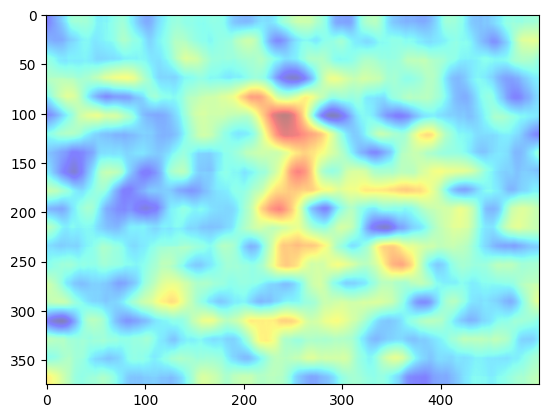

In [29]:
plt.imshow(weighted_mask , cmap='jet' , alpha=0.5)

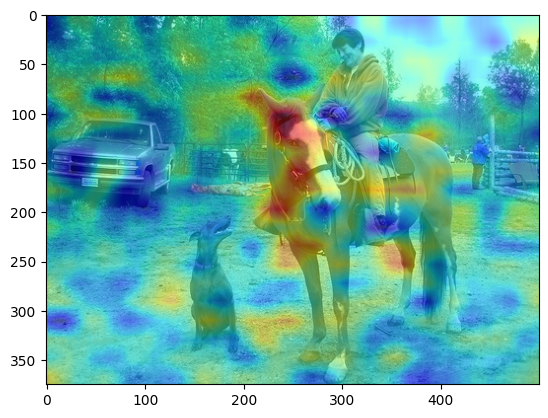

In [30]:
img = cv2.imread(f'../simple-faster-rcnn-pytorch\misc\{image_name}.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# draw out detection on top of image

plt.imshow(img[:, :, ::-1])
plt.imshow(weighted_mask, cmap='jet', alpha=0.5)